In [122]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, MultiPoint
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as off
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth

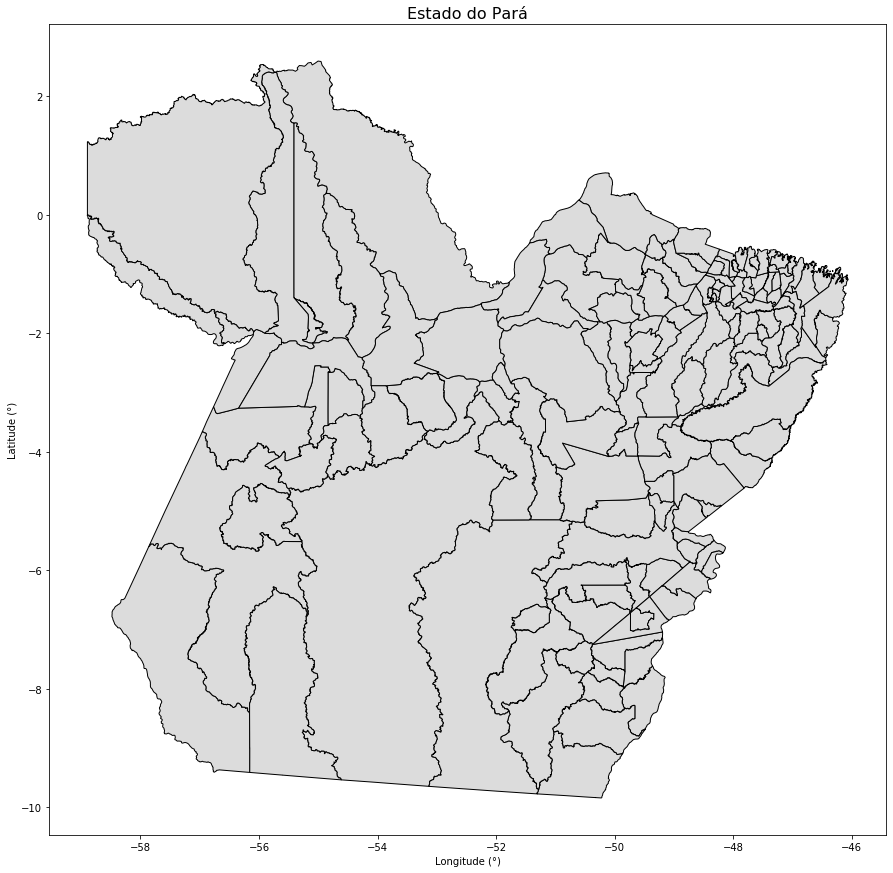

In [113]:
state = gpd.read_file('../data/shapes/pa_municipios/15MUE250GC_SIR.shp', encoding='utf-8')
state.plot(color='#dcdcdc', edgecolor='k', figsize=(15, 15))
plt.title('Estado do Pará', fontdict=dict(size=16))
plt.xlabel('Longitude (°)')
plt.ylabel('Latitude (°)')
plt.show()

Text(0.5, 337.4770900948511, 'Longitude (°)')

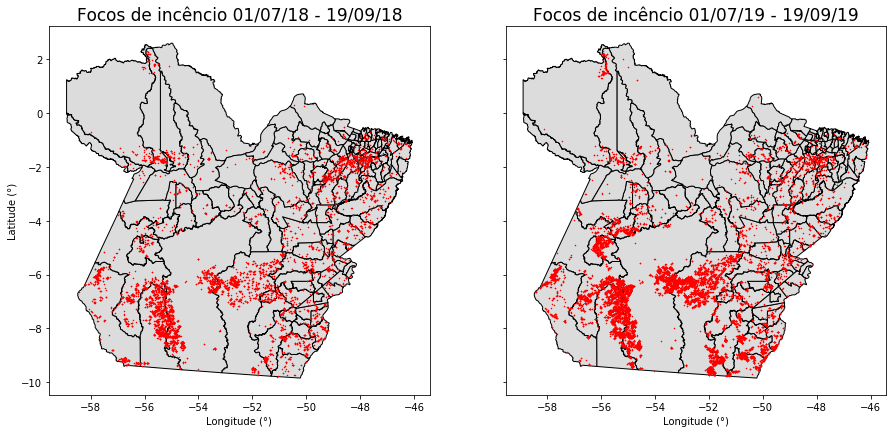

In [114]:
focus2018 = gpd.read_file('../data/focos/Focos.2018-07-01.2018-09-19.shp/')
focus2019 = gpd.read_file('../data/focos/Focos.2019-07-01.2019-09-19.shp/')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(15,15))
fonttitle = dict(size=17)
state.plot(ax=ax1, color='#dcdcdc', edgecolor='k')
state.plot(ax=ax2, color='#dcdcdc', edgecolor='k')

focus2018.plot(ax=ax1, marker='*', markersize=.4, color='red')
focus2019.plot(ax=ax2, marker='*', markersize=.4, color='red')

ax1.set_title('Focos de incêncio 01/07/18 - 19/09/18', fontdict=fonttitle)
ax2.set_title('Focos de incêncio 01/07/19 - 19/09/19', fontdict=fonttitle)

ax1.set_ylabel('Latitude (°)')
ax1.set_xlabel('Longitude (°)')
ax2.set_xlabel('Longitude (°)')

In [115]:
def get_points_in_polygons(polygons, points, 
                           xcol='Longitud', ycol='Latitude',
                           groupby='NM_MUNICIP', split=False):
    result = {}
    for i, point in points.iterrows():
        x, y = point[xcol], point[ycol]
        point_test = Point(x, y)

        for i, polygon in polygons.iterrows():
            geom = polygon['geometry']
            group = polygon[groupby]
            if geom.contains(point_test):
                if not result.get(group):
                    result[group] = 0
                result[group] += 1
                break
    return (result.keys(), result.values()) if split else result


def find(l, v):
    for i, x in enumerate(l):
        if v == x:
            return True, i
    return False, 0


def density_polygons(polygons, keys, values, groupby='NM_MUNICIP'):
    result = []
    for i, polygon in polygons.iterrows():
        group = polygon[groupby]
        found = False
        contains, index = 0, 0
        for key in keys:
            contains, index = find(keys, group)
            if contains:
                found = True
                break
        if found:    
            result.append(values[index])
        else:
            result.append(0)

    return result

In [116]:
'''Extract fire focus by city (2018 and 2019)
'''
# keys2018, values2018 = \
#     get_points_in_polygons(state, focus2018, split=True)

# keys2019, values2019 = \
#     get_points_in_polygons(state, focus2019, split=True)

'Extract fire focus by city (2018 and 2019)\n'

In [117]:
'''Set and save shapefile with columns of fire focus (2018 and 2019)
'''
# f2018 = density_polygons(state, list(keys2018), 
#                          list(values2018))
# f2019 = density_polygons(state, list(keys2019), 
#                          list(values2019))
# state['focos_2018'] = f2018
# state['focos_2019'] = f2019
# state.to_file('../data/shapes/state_with_focus/focus_complet.shp', 
#               encoding = 'utf-8')

'Set and save shapefile with columns of fire focus (2018 and 2019)\n'

In [118]:
state = gpd.read_file('../data/shapes/state_with_focus/focus_complet.shp', 
                     encoding='utf-8')
state.head()

,NM_MUNICIP,CD_GEOCMU,focos_2018,focos_2019,geometry
0,ALENQUER,1500404,49,35,POLYGON ((-54.86211511799996 0.372521589012336...
1,ALMEIRIM,1500503,2,12,POLYGON ((-54.87225092899999 2.433746586080204...
2,ALTAMIRA,1500602,1243,3267,POLYGON ((-51.95812355600002 -3.47704330411428...
3,AVEIRO,1501006,28,88,POLYGON ((-55.23386972699995 -3.24192074610664...
4,BELTERRA,1501451,5,21,POLYGON ((-54.83244893099985 -2.66109809308753...


In [119]:
increased = state.query('focos_2018 < focos_2019')
decreased = state.query('focos_2018 > focos_2019')
equals = state.query('focos_2018 == focos_2019')
cities = state['NM_MUNICIP'].values

fig = go.Figure()

v2018, v2019 = increased['focos_2018'].values, \
               increased['focos_2019'].values
fig.add_trace(
    go.Bar(x=cities, y=v2019-v2018, name='Focos a mais reportados',
          marker=dict(color='red'))
)

v2018, v2019 = decreased['focos_2018'].values, \
               decreased['focos_2019'].values
fig.add_trace(
    go.Bar(x=cities, y=v2018-v2019, name='Focos a menos reportados',
           marker=dict(color='blue'))
)

fig.update_yaxes(title_text='Direrença em entre 2018 e 2019')

fig.update_layout(
    showlegend=True,
    title='Comparação da diferença de aumento e diminuição dos focos de \
incêndios reportados <br>Período de 01 de julho a 19 de setembro de cada ano'
)
off.iplot(fig)

In [120]:
fig = go.Figure()

fig.add_trace(
    go.Pie(values=[increased['NM_MUNICIP'].count(),
           decreased['NM_MUNICIP'].count(),
           equals['NM_MUNICIP'].count()], 
           labels=['Municípios com aumento de focos', 
                   'Municípios com diminuição de focos',
                  'Municípios com a mesma quantidade de focos'],
           marker=dict(colors=['red', 'green', 'blue']),
           name='Focos a mais reportados')
)

fig.update_layout(
    showlegend=True,
    title='Comparação da diferença de aumento e diminuição dos focos de \
incêndios reportados <br>Período de 01 de julho a 19 de setembro de cada ano'
)
off.iplot(fig)

number of estimated clusters : 20


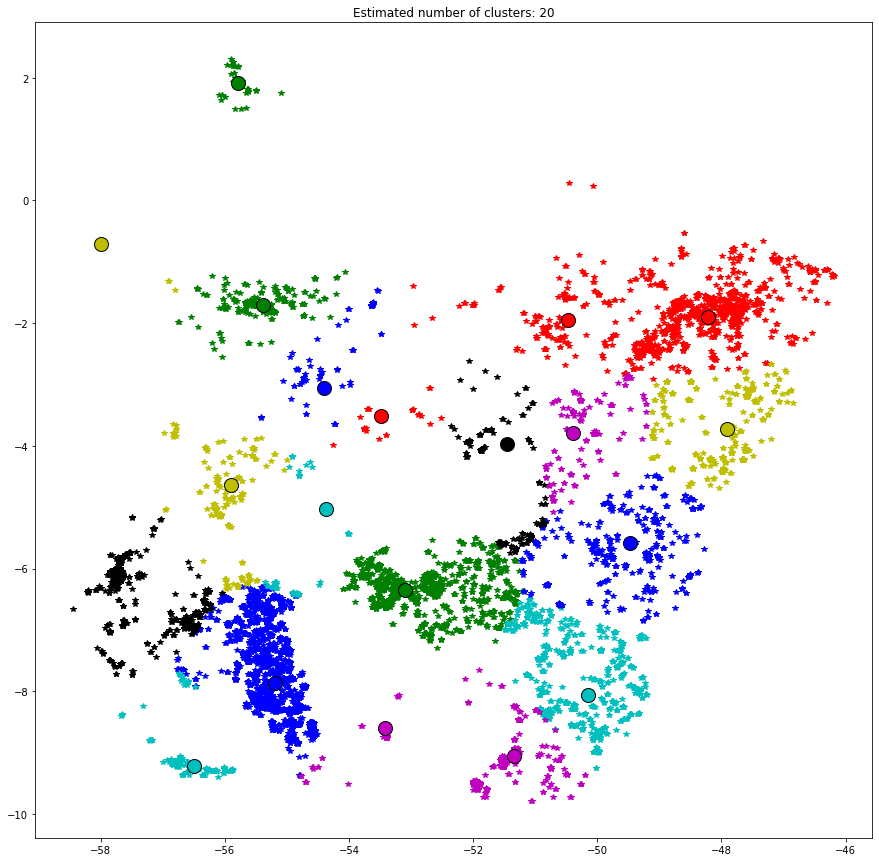

In [126]:
lat2018 = focus2018.Latitude.values
lon2018 = focus2018.Longitud.values

values = pd.DataFrame({'lon': lon2018, 'lat': lat2018}).values
bandwidth = estimate_bandwidth(values, quantile=0.051, 
                               n_samples=None, random_state=0)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(values)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

X = values
import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(figsize=(15, 15))
plt.clf()


colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '*')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()